# Supervised Learning.

* Conduct feature engineering.
* Run basic models.
* Conduct hypertuning, ablation studies, and feature importance.
* Add in new feature engineering.
* Iterate and repeat.
* Failure analysis on final model.


### Import Packages

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import math

# preprocessing.
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures

# Supervised learning.
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Hyperparameter tuning.
from sklearn.model_selection import GridSearchCV

# visualization.
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import altair as alt
alt.data_transformers.disable_max_rows()

# Progress tracking.
from tqdm import tqdm

# Show all columns
pd.set_option('display.max_columns', None)

# NLP.
import spacy
nlp = spacy.load("en_core_web_sm")
import nltk

# Manage error messages.
import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore")

# Import Data.

Import the data from the unsupervised learning portion of the project. Read in other datasets as well.

In [2]:
airbnb_df = pd.read_csv('UNSUPERVISED_LEARNING airbnb_data.csv').drop(columns=['Unnamed: 0'])
county_df = pd.read_csv('CLEANED county_data.csv').drop(columns=['Unnamed: 0'])
parks_df = pd.read_csv('CLEANED natl_state_park_by_us_state.csv')
image_df = pd.read_csv('CLEANED image_quality BACKUP.csv')

# Feature Generation

As part of an insight found in after a few iterations of this notebook, a few different feature categories were generated.
* Destination data: Calculating the Euclidean distance between each listing and an array of 150 different destinations curated from Planetware.com.
* Unigram text extraction: Pull out common unigrams from the text.
* Image Quality analytics: The IQA's were pulled out into a separate notebook, assessing the quality of the first 5 images of the listing.

# Destination Data.

In [3]:
# Read in manually curated destination data.
dest_df = pd.read_csv('CLEANED destinations.csv')
dest_df.head()

Latitude  Longitude                          Park  \
0     38.68    -109.57                        Arches   
1     38.57    -107.72  Black Canyon of the Gunnison   
2     37.57    -112.18                  Bryce Canyon   
3     38.20    -109.93                   Canyonlands   
4     38.20    -111.17                  Capitol Reef   

                park_short_code  
0                        arches  
1  black_canyon_of_the_gunnison  
2                  bryce_canyon  
3                   canyonlands  
4                  capitol_reef

In [4]:
# Function for calculating the Euclidean distance between a listing and a destination.
def listing_location_distance(first_lat, first_lng, second_lat, second_lng):
    return math.dist([first_lat, first_lng], [second_lat, second_lng])

In [5]:
# A dictionary for values.
dict_ = {}

# For each destination.
for i, dest_row in dest_df.iterrows():
    
    # Get the destination's short code and lat/lng.
    park = dest_row['park_short_code']
    first_lat = dest_row['Latitude']
    first_lng = dest_row['Longitude']
    
    # A list for values.
    values = []
    
    # For each listing.
    for j, list_row in airbnb_df.iterrows():
        
        # Get the lat/lng of the listing.
        second_lat = list_row['latitude']
        second_lng = list_row['longitude']
        
        # Calculate the Euclidean distance.
        dist = listing_location_distance(first_lat, first_lng, second_lat, second_lng)
        
        # Append Euclidean distance to list.
        values.append(dist)
    
    print('{} processed.'.format(park))
    
    # Add the list as the value with the key being the park short code.
    dict_[park] = values

arches processed.
black_canyon_of_the_gunnison processed.
bryce_canyon processed.
canyonlands processed.
capitol_reef processed.
carlsbad_caverns processed.
channel_islands processed.
death_valley processed.
glacier processed.
grand_canyon processed.
grand_teton processed.
great_basin processed.
great_sand_dunes processed.
joshua_tree processed.
kings_canyon processed.
lassen_volcanic processed.
mesa_verde processed.
mount_rainier processed.
north_cascades processed.
olympic processed.
petrified_forest processed.
pinnacles processed.
redwood processed.
rocky_mountain processed.
saguaro processed.
sequoia processed.
yellowstone processed.
yosemite processed.
zion processed.
golden_gate_bridge processed.
disneyland processed.
big_sur processed.
lake_tahoe processed.
universal_studios_hollywood processed.
hearst_castle processed.
santa_catalina_island processed.
the_getty processed.
palm_springs_aerial_tramway processed.
griffith_observatory processed.
uss_midway_museum processed.
columbi

In [6]:
# Convert the dictionary into a DataFrame.
destination_df = pd.DataFrame(data=dict_)
destination_df.head()

arches  black_canyon_of_the_gunnison  bryce_canyon  canyonlands  \
0  6.534520                      4.711505      9.277106     6.952157   
1  6.535274                      4.712372      9.278034     6.953032   
2  8.422667                      7.183663     11.168810     9.007477   
3  6.822129                      5.020602      9.222847     7.067531   
4  7.190514                      5.614334     10.026324     7.721121   

   capitol_reef  carlsbad_caverns  channel_islands  death_valley    glacier  \
0      8.179062          7.254575        17.187749     14.090422  14.490478   
1      8.179892          7.256627        17.188900     14.091408  14.489609   
2      9.981086         11.972833        19.173887     15.799628  11.887428   
3      8.289887          4.962922        16.693882     13.855827  16.208567   
4      8.849341          9.565367        18.090606     14.822370  13.121735   

   grand_canyon  grand_teton  great_basin  great_sand_dunes  joshua_tree  \
0      9.634335     8.917887    11.240067          2.902461    13.965593   
1      9.635537     8.917397    11.240692          2.904008    13.966898   
2     12.079671     7.711981    12.305355          6.781523    16.418789   
3      9.199128    10.373463    11.506540          2.657973    13.291663   
4     10.692564     8.066998    11.594810          4.630026    15.084626   

   kings_canyon  lassen_volcanic  mesa_verde  mount_rainier  north_cascades  \
0     15.685087        18.484512    5.822615      20.156014       20.430290   
1     15.685965        18.484952    5.823865      20.155801       20.429885   
2     17.077926        18.758823    8.748361      18.861046       18.687984   
3     15.569864        18.871460    5.515893      21.237389       21.699549   
4     16.271182        18.533339    7.056784      19.452356       19.514813   

     olympic  petrified_forest  pinnacles    redwood  rocky_mountain  \
0  22.201568          7.933094  18.313038  21.031696        2.748523   
1  22.201319          7.934631  18.313905  21.032075        2.748248   
2  20.774523         11.208552  19.593215  21.086951        4.429541   
3  23.308678          7.044923  18.184617  21.472281        4.348904   
4  21.447432          9.424417  18.864414  20.990925        2.846885   

     saguaro    sequoia  yellowstone   yosemite       zion  \
0  10.241718  15.875983     9.135353  16.500690  10.182643   
1  10.243493  15.876900     9.134667  16.501433  10.183589   
2  13.945317  17.355265     7.423762  17.550285  12.036933   
3   8.848173  15.706893    10.752893  16.544855  10.076866   
4  12.001028  16.508118     8.056526  16.920158  10.931665   

   golden_gate_bridge  disneyland    big_sur  lake_tahoe  \
0           19.469813   15.833572  18.985946   16.969244   
1           19.470532   15.834793  18.986824   16.969837   
2           20.364788   18.025100  20.271998   17.651235   
3           19.518808   15.256993  18.838529   17.191058   
4           19.835660   16.832099  19.545129   17.207959   

   universal_studios_hollywood  hearst_castle  santa_catalina_island  \
0                    16.134722      18.459885              16.448517   
1                    16.135895      18.460831              16.449760   
2                    18.204167      19.921911              18.675529   
3                    15.621372      18.229078              15.833259   
4                    17.072492      19.104423              17.470111   

   the_getty  palm_springs_aerial_tramway  griffith_observatory  \
0  16.268308                    14.606969             16.090833   
1  16.269483                    14.608237             16.092010   
2  18.338120                    16.953118             18.170547   
3  15.750874                    13.976330             15.572741   
4  17.207323                    15.675679             17.033557   

   uss_midway_museum  columbia_river_gorge  cannon_beach  \
0          15.569244             19.816536     21.914341   
1          15.570597             19.816438

In [7]:
# Concatenate destinations to DataFrame.
airbnb_df = pd.concat([airbnb_df, destination_df, image_df], axis=1)

In [8]:
airbnb_df.head()

listing_id                            listing_url  is_superhost  \
0    47924385  https://www.airbnb.com/rooms/47924385             1   
1    12964075  https://www.airbnb.com/rooms/12964075             1   
2    42124659  https://www.airbnb.com/rooms/42124659             1   
3     4596261   https://www.airbnb.com/rooms/4596261             1   
4    27028111  https://www.airbnb.com/rooms/27028111             1   

   is_premium  rating  n_reviews        country     state        city  \
0           0    4.86      207.0  United States  Colorado     Flagler   
1           0    4.87      419.0  United States  Colorado     Flagler   
2           0    4.84      310.0  United States  Colorado  Rapid City   
3           0    4.96      114.0  United States  Colorado      Kenton   
4           0    4.96      119.0  United States  Colorado  Bridgeport   

              county postcode               listing_title  n_pictures  \
0  Kit Carson County  80815.0             Home in Flagler         9.0   
1  Kit Carson County  80815.0     Private room in Flagler        11.0   
2  Kit Carson County  80815.0  Private room in Rapid City         8.0   
3  Kit Carson County  80815.0         Farm stay in Kenton        30.0   
4  Kit Carson County  80815.0         Cabin in Bridgeport        11.0   

   entire_home  hotel_room  private_room  shared_room  latitude  longitude  \
0            1           0             0            0  39.29294 -103.06429   
1            0           0             1            0  39.29492 -103.06372   
2            0           0             1            0  44.06709 -103.09539   
3            1           0             0            0  36.91348 -102.98055   
4            1           0             0            0  41.62812 -103.01164   

   price  perc_discount  n_guests  n_bedrooms  n_beds  n_baths  \
0     77       0.000000       3.0         1.0     1.0      1.0   
1     65       0.000000       3.0         1.0     1.0      1.0   
2     35       0.466667       2.0         1.0     1.0      1.0   
3    150       0.000000      11.0         4.0     4.0      2.0   
4     90       0.000000       7.0         2.0     4.0      1.0   

   rating_cleanliness  rating_communication  rating_checkin  rating_accuracy  \
0                 4.8                   5.0             4.9              4.9   
1                 4.8                   4.9             5.0              5.0   
2                 4.9                   4.9             4.9              4.9   
3                 5.0                   5.0             5.0              5.0   
4                 5.0                   5.0             5.0              5.0   

   rating_location  rating_value  n_amenities  amenities_services  \
0              4.9           4.9         35.0                 3.0   
1              4.9           4.9         31.0                 3.0   
2              4.8           4.9         34.0                 4.0   
3              5.0           5.0         69.0                 4.0   
4              5.0           5.0         40.0                 2.0   

   amenities_heat_cool  amenities_bedroom_laundry  amenities_kitchen_dining  \
0                  2.0                       10.0                       5.0   
1                  3.0                        7.0                       4.0   
2                  2.0                        5.0                      10.0   
3                  6.0                        9.0                      16.0   
4                  3.0                        4.0                      11.0   

   amenities_safety  amenities_parking_facilities  amenities_internet_office  \
0               4.0                           2.0                        2.0   
1               2.0                           2.0                        2.0   
2               5.0                           3.0                        1.0   
3               5.0                           1.0                        2.0   
4               4.0                           1.0                  

Intuitively, you can think of these destination features as a casting a "net", tracing lines to each destination from the listing. You can see what this looks like below.

In [9]:
# Returns visual demonstrating the destination net.

def plot_destination_net():
    
    for i, row in dest_df.iterrows():
        plt.plot([airbnb_df['longitude'][0], row['Longitude']],
                 [airbnb_df['latitude'][0], row['Latitude']], 
                 color='k',alpha=0.1, linestyle='dashed')
        
    plt.scatter(airbnb_df['longitude'],airbnb_df['latitude'],s=1,alpha=0.05)
    plt.scatter(airbnb_df['longitude'][0],airbnb_df['latitude'][0],s=30,color='red')
    plt.scatter(dest_df['Longitude'], dest_df['Latitude'],s=15,color='purple',alpha=0.5)
    
    plt.title('Destination Net')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

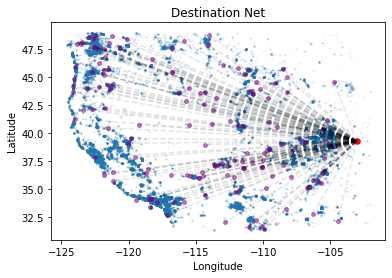

In [10]:
plot_destination_net()

# Text feature generation

* Generate the most common unigrams to review.
* One-hot encode common, interesting unigrams into features for the dataset.

In [11]:
# Import some libraries that are helpful.
from operator import itemgetter
from nltk.corpus import stopwords

# Get stop words.
nltk_stop = stopwords.words('english')

# Feature to extract unigrams.
def get_text(x,dict_,token_type='unigram'):
    try:
        x = x.lower()
        tb_tok = nltk.tokenize.treebank.TreebankWordTokenizer()
        tokens = tb_tok.tokenize(x)
        
        if token_type == 'bigram':
            tokens = list(nltk.bigrams(tokens))
            
            for token in tokens:
                if token[0] not in nltk_stop and tokens[1] not in nltk_stop:
                    if token in dict_.keys():
                        dict_[token] += 1
                    else:
                        dict_[token] = 1
        
        if token_type == 'unigram':
            for token in tokens:
                if token not in nltk_stop:
                    if token in dict_.keys():
                        dict_[token] += 1
                    else:
                        dict_[token] = 1
        return dict_
    except:
        return dict_

In [12]:
# Generate dictionary of unigrams.
dict_unigram = {}
for i, row in airbnb_df.iterrows():
    dict_unigram = get_text(row['description'],dict_=dict_unigram,token_type='unigram')

In [13]:
# Print top 1,000 unigrams.
print(sorted(dict_unigram.items(), key=itemgetter(1), reverse=True)[:1000])

[(',', 1724756), (')', 180821), ('!', 175389), ('(', 172858), (':', 163794), ('home', 132823), ('room', 129594), ('.', 95859), ('private', 95701), ('bedroom', 94481), ('&', 90491), ('kitchen', 90067), ('2', 89201), ('house', 86319), ('bed', 84765), ('please', 80380), ('living', 79748), ('access', 79601), ('-', 78824), ('enjoy', 77339), ('guests', 76061), ('area', 72887), ("'s", 71829), ('located', 71504), ('one', 70392), ('full', 69035), ('things', 68768), ('two', 67092), ('large', 65802), ('also', 65648), ('parking', 65177), ('property', 64899), ('space', 59848), ('queen', 59257), ('guest', 57513), ('outdoor', 51269), ('bathroom', 51046), ('tv', 50895), ('hot', 50808), ('mountain', 49488), ('available', 49322), ('dining', 46795), ('1', 46746), ('stay', 46432), ('minutes', 46059), ('$', 44401), ('park', 44391), ('coffee', 44379), ('great', 44221), ('beautiful', 43852), ('pool', 43450), ('front', 42862), ('use', 42384), ('miles', 42134), ('views', 41962), ('3', 41890), ('may', 40854), (

### Unigrams of note

After reviewing the unigrams, here are some ones I find interesting.

* mountain
* beautiful
* pool
* coffee
* cabin
* beach
* deck
* walk
* lake
* spacious
* water
* hiking
* retreat
* historic
* ocean
* forest
* snow
* biking
* skiing
* peaceful
* acres
* animals
* canyon
* stunning
* basement
* farm
* escape
* sunset
* jacuzzi
* breathtaking

### Second pass (>300USD listings)

* views
* large
* river
* coffee
* private
* property
* golf
* outdoor 
* security
* swimming
* coast
* housekeeping
* gondola
* hardwood
* resort

In [14]:
# Tokenizer.
tb_tok = nltk.tokenize.treebank.TreebankWordTokenizer()

# Function for one-hot encoding unigrams.
def gen_unigram_features(x,gram):
    try:
        x = x.lower()
        tokens = tb_tok.tokenize(x)
        
        if gram in x:
            return 1
        else:
            return 0
    except:
        return 0
    

In [15]:
unigrams = ['mountain', 'beautiful', 'pool', 'coffee', 'cabin', 'beach', 'deck', 'walk', 'lake', 
'spacious', 'water', 'hiking', 'retreat', 'historic', 'ocean', 'forest', 'snow', 'biking', 'skiing', 
'peaceful', 'acres', 'animals', 'canyon', 'stunning', 'basement', 'farm', 'escape', 'sunset', 
'jacuzzi', 'breathtaking'] 

In [16]:
# Execute one-hot encoding.
for unigram in tqdm(unigrams):
    airbnb_df[unigram] = airbnb_df['description'].apply(lambda x: gen_unigram_features(x, gram=unigram))

100%|██████████| 30/30 [33:02<00:00, 66.09s/it]


After a second iteration, here are some interesting and common unigrams that are showing up for higher priced listings (the ones experiencing higher errors).

In [17]:
unigrams = [
    'views',
    'large',
    'river',
    'coffee',
    'private',
    'property',
    'golf',
    'outdoor', 
    'security',
    'swimming',
    'coast',
    'housekeeping',
    'gondola',
    'hardwood',
    'resort']

In [18]:
# One-hot encode second round of unigrams.
for unigram in tqdm(unigrams):
    airbnb_df[unigram] = airbnb_df['description'].apply(lambda x: gen_unigram_features(x, gram=unigram))

100%|██████████| 15/15 [16:32<00:00, 66.18s/it]


# One-hot encode state-county

Hypothesis: this might be more interesting geographic information to add to the model.

**Abandoned in final model.**

In [19]:
"""
airbnb_df['state_county'] = airbnb_df['state'] + '_' + airbnb_df['county']

# Get one hot encoding of columns B
one_hot = pd.get_dummies(airbnb_df['state_county'])

# Drop column B as it is now encoded
airbnb_df = airbnb_df.drop('state_county',axis = 1)

# Join the encoded df
airbnb_df = airbnb_df.join(one_hot)
"""

"\nairbnb_df['state_county'] = airbnb_df['state'] + '_' + airbnb_df['county']\n\n# Get one hot encoding of columns B\none_hot = pd.get_dummies(airbnb_df['state_county'])\n\n# Drop column B as it is now encoded\nairbnb_df = airbnb_df.drop('state_county',axis = 1)\n\n# Join the encoded df\nairbnb_df = airbnb_df.join(one_hot)\n"

# Look at output

In [20]:
airbnb_df = airbnb_df.drop(columns=['Unnamed: 0','image_1_size','image_2_size','image_3_size','image_4_size','image_5_size'])

In [21]:
airbnb_df.head()

listing_id                            listing_url  is_superhost  \
0    47924385  https://www.airbnb.com/rooms/47924385             1   
1    12964075  https://www.airbnb.com/rooms/12964075             1   
2    42124659  https://www.airbnb.com/rooms/42124659             1   
3     4596261   https://www.airbnb.com/rooms/4596261             1   
4    27028111  https://www.airbnb.com/rooms/27028111             1   

   is_premium  rating  n_reviews        country     state        city  \
0           0    4.86      207.0  United States  Colorado     Flagler   
1           0    4.87      419.0  United States  Colorado     Flagler   
2           0    4.84      310.0  United States  Colorado  Rapid City   
3           0    4.96      114.0  United States  Colorado      Kenton   
4           0    4.96      119.0  United States  Colorado  Bridgeport   

              county postcode               listing_title  n_pictures  \
0  Kit Carson County  80815.0             Home in Flagler         9.0   
1  Kit Carson County  80815.0     Private room in Flagler        11.0   
2  Kit Carson County  80815.0  Private room in Rapid City         8.0   
3  Kit Carson County  80815.0         Farm stay in Kenton        30.0   
4  Kit Carson County  80815.0         Cabin in Bridgeport        11.0   

   entire_home  hotel_room  private_room  shared_room  latitude  longitude  \
0            1           0             0            0  39.29294 -103.06429   
1            0           0             1            0  39.29492 -103.06372   
2            0           0             1            0  44.06709 -103.09539   
3            1           0             0            0  36.91348 -102.98055   
4            1           0             0            0  41.62812 -103.01164   

   price  perc_discount  n_guests  n_bedrooms  n_beds  n_baths  \
0     77       0.000000       3.0         1.0     1.0      1.0   
1     65       0.000000       3.0         1.0     1.0      1.0   
2     35       0.466667       2.0         1.0     1.0      1.0   
3    150       0.000000      11.0         4.0     4.0      2.0   
4     90       0.000000       7.0         2.0     4.0      1.0   

   rating_cleanliness  rating_communication  rating_checkin  rating_accuracy  \
0                 4.8                   5.0             4.9              4.9   
1                 4.8                   4.9             5.0              5.0   
2                 4.9                   4.9             4.9              4.9   
3                 5.0                   5.0             5.0              5.0   
4                 5.0                   5.0             5.0              5.0   

   rating_location  rating_value  n_amenities  amenities_services  \
0              4.9           4.9         35.0                 3.0   
1              4.9           4.9         31.0                 3.0   
2              4.8           4.9         34.0                 4.0   
3              5.0           5.0         69.0                 4.0   
4              5.0           5.0         40.0                 2.0   

   amenities_heat_cool  amenities_bedroom_laundry  amenities_kitchen_dining  \
0                  2.0                       10.0                       5.0   
1                  3.0                        7.0                       4.0   
2                  2.0                        5.0                      10.0   
3                  6.0                        9.0                      16.0   
4                  3.0                        4.0                      11.0   

   amenities_safety  amenities_parking_facilities  amenities_internet_office  \
0               4.0                           2.0                        2.0   
1               2.0                           2.0                        2.0   
2               5.0                           3.0                        1.0   
3               5.0                           1.0                        2.0   
4               4.0                           1.0                  

# Removing Outliers

Let's remove anything greater than $800 (4.1% of the data). We'll focus on a model that can predict "normal" listings, avoiding higher priced listings.

In [22]:
# See where the cut off should be.
print('% of Total Records')
print('$5,000+/night:', str(round(len(airbnb_df[airbnb_df['price'] > 5000])/len(airbnb_df)*100,3)) + '%')
print('$4,000+/night:', str(round(len(airbnb_df[airbnb_df['price'] > 4000])/len(airbnb_df)*100,3)) + '%')
print('$3,000+/night:', str(round(len(airbnb_df[airbnb_df['price'] > 3000])/len(airbnb_df)*100,3)) + '%')
print('$2,000+/night:', str(round(len(airbnb_df[airbnb_df['price'] > 2000])/len(airbnb_df)*100,3)) + '%')
print('$1,000+/night:', str(round(len(airbnb_df[airbnb_df['price'] > 1000])/len(airbnb_df)*100,3)) + '%')
print('$800+/night:', str(round(len(airbnb_df[airbnb_df['price'] > 800])/len(airbnb_df)*100,3)) + '%')

% of Total Records
$5,000+/night: 0.091%
$4,000+/night: 0.145%
$3,000+/night: 0.258%
$2,000+/night: 0.609%
$1,000+/night: 2.568%
$800+/night: 4.185%


In [23]:
# Drop outliers (identified in advance).
airbnb_df = airbnb_df[(airbnb_df['price'] <= 800)].reset_index().drop(columns=['index'])

# Model Pre-Processing

Let's get the data in shape for the model.

In [24]:
# model data.

# copy data.
airbnb_model = airbnb_df.copy()

# columns that are not int/floats, or that deal with geography.
dropcols = ['listing_url','country','state','city','county','postcode','listing_title',
       'latitude','longitude','description','image_1','image_2','image_3','image_4','image_5','listing_id',
           'mahalanobis_100','wminkowski_500','cos100','cor100']

# drop columns.
airbnb_model.drop(columns=dropcols, inplace=True)

# Split X and y.
y = airbnb_model['price'].values
X = airbnb_model.drop(columns=['price'])

# Impute missing values with the median.
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X = imp_median.fit_transform(X)

# Basic Modeling.

In [25]:
# Create two helper functions to help draw a 95% confidence interval around the viualized data.

# Calculate moving average.
def moving_average(a, n=14) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def confidence_intervals(y_pred, y_test):
    
    # Lists.
    floor_values = []
    roof_values = []
    
    # Get 95% CI's for roof/floor values.
    for i in range(0,601):        
        arr = y_test[np.where(np.around(y_pred) == i)]
        try:
            floor_values.append(np.percentile(arr, 2.5))
            roof_values.append(np.percentile(arr, 97.5))
        except:
            try:
                floor_values.append(floor_values[i-1])
                roof_values.append(roof_values[i-1])
            except:
                floor_values.append(0)
                roof_values.append(0)
     
    # Calculate 14 period moving average for smoothing.
    floor_values = np.concatenate([floor_values[:13], moving_average(floor_values)])
    roof_values = np.concatenate([roof_values[:13], moving_average(roof_values)])
    
    return floor_values, roof_values

In [26]:
# Function to train, predict, and visualize model. 
# A few kwargs have been abandoned in the final implementation.
def gen_model(X,y,model,ax,polynomial=False,transform=None,log=False):
    
    # Copy data.
    X_ = X.copy()
    y_ = y.copy()
    
    if polynomial==False:
        # Train model, keep indices of values used in dataset.

        X_train, X_test, y_train, y_test = train_test_split(
            X_, y_, test_size=0.2, random_state=0
        )
        
        # Hacky way to track which listings are used in train split.
        _, map_frame, _, _ = train_test_split(
         np.array(airbnb_df[['listing_url']].reset_index()), y_, test_size=0.2, random_state=0)
        
    else:
        # Polynomial model (abandoned).
        
        poly = PolynomialFeatures(degree = polynomial)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X_, y_, test_size=0.3, random_state=0
        )
        
        X_train = poly.fit_transform(X_train)
        X_test = poly.transform(X_test)
        
    if log == True:
        
        # Log model (abandoned).
        
        y_train = np.log(y_train)
        y_test = np.log(y_test)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    else:
        # Fit model.
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Get 1-fold metrics.
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Get 5-fold metrics.
    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    r2_scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=cv, n_jobs=-1)
    mae_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    rmse_scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    
    # Create the data visualization.
    floor, roof = confidence_intervals(y_pred, y_test)
    
    # Define delimiter.
    try:
        delimiter = min([max([max(y_pred)[0], max(y_test.values)[0]]),800])
    except:
        delimiter = min([max([y_pred.max(), y_test.max()]),800])
    
    # Creat chart.
    ax.scatter(y_pred, y_test, alpha=0.05)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xlim(0, delimiter)
    ax.set_ylim(0, delimiter)
    ax.set_title(str(model))
    ax.text(delimiter*.8, delimiter*.49, 'R2, avg: {}'.format(round(np.mean(r2_scores),3)))
    ax.text(delimiter*.8, delimiter*.45, 'R2, std: {}'.format(round(np.std(r2_scores),3)))
    ax.text(delimiter*.8, delimiter*.41, 'MAE, avg: {}'.format(round(np.mean(mae_scores),3)))
    ax.text(delimiter*.8, delimiter*.37, 'MAE, std: {}'.format(round(np.std(mae_scores),3)))
    ax.text(delimiter*.8, delimiter*.33, 'RMSE, avg: {}'.format(round(np.mean(rmse_scores),3)))
    ax.text(delimiter*.8, delimiter*.29, 'RMSE, std: {}'.format(round(np.std(rmse_scores),3)))
    ax.text(delimiter*.8, delimiter*.25, 'RMSE: {}'.format(round(rmse)))
    ax.text(delimiter*.8, delimiter*.21, 'MAE: {}'.format(round(mae)))
    ax.text(delimiter*.8, delimiter*.17, 'R2: {}'.format(round(r2,3)))
    
    ax.plot(np.linspace(0, round(delimiter), round(delimiter)*100), 
             np.linspace(0, round(delimiter), round(delimiter)*100),
            c='red',label='accurate prediction')
    
    ax.plot(range(0,601), roof, c='k',linestyle='dashed',label='95% confidence intervals')
    ax.plot(range(0,601), floor, c='k',linestyle='dashed')
    ax.legend()
    
    return y_pred, y_test, map_frame

### Test out a few basic, untuned model.

4it [13:54, 208.66s/it]


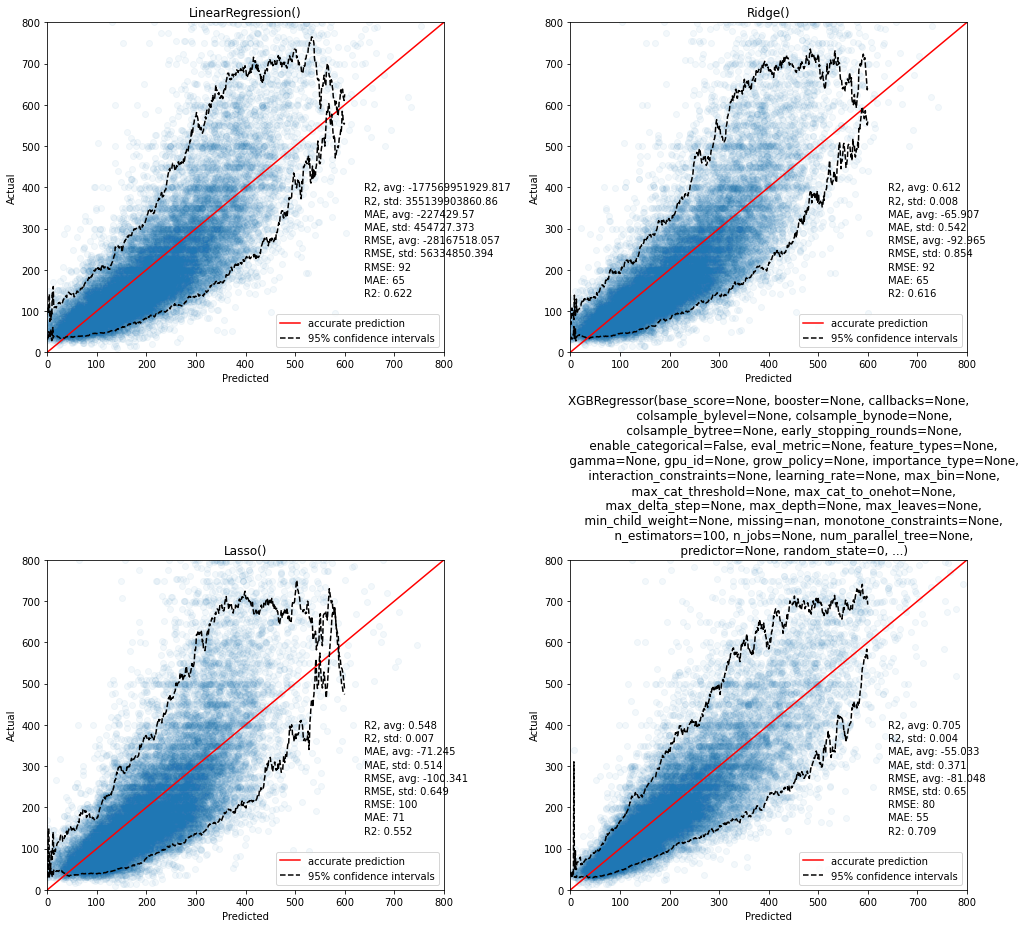

In [27]:
# Create subplots.
fig, axes = plt.subplots(2, 2, figsize=(14, 13))
axes = axes.flatten()

# Create models.
models=[LinearRegression(), Ridge(), Lasso(), 
        #RandomForestRegressor(n_jobs=-1),
        #GradientBoostingRegressor(),
        XGBRegressor(random_state=0)     
       ]

# Loop through and create charts.
for i, ax in tqdm(enumerate(axes)):
    gen_model(X,y,models[i],ax,log=False)
    
plt.tight_layout()

### 2-Degree Polynomial LinearRegression, Ridge, Lasso.

Create 2-degree polynomial model.

**Abandoned in final model.**

In [ ]:
"""
fig, axes = plt.subplots(1, 2, figsize=(14, 10))
axes = axes.flatten()

models=[XGBRegressor(random_state=0),XGBRegressor(random_state=0)]

for i, ax in tqdm(enumerate(axes)):
    if i == 0:
        gen_model(X,y,models[i],ax,polynomial=2)
    else:
        gen_model(X,y,models[i],ax)
    
plt.tight_layout()
"""

# Hyperparameter Tuned Models.

**Abandoned in final model**. Hyperparameter tuning is handled in other functions more specific to tree-based models.

In [ ]:
"""
def gen_tuned_model(X,y,model,ax,parameters,polynomial=False,transform=None):
    
    X_ = X.copy()
    y_ = y.copy()
    
    if polynomial==False:
    

        X_train, X_test, y_train, y_test = train_test_split(
            X_, y_, test_size=0.2, random_state=0
        )
        
    else:
        
        poly = PolynomialFeatures(degree = polynomial)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X_, y_, test_size=0.2, random_state=0
        )
        
        X_train = poly.fit_transform(X_train)
        X_test = poly.transform(X_test)
    
    
    cv_search = GridSearchCV(model, parameters, scoring='r2',cv=5)
    
    cv_search.fit(X_train, y_train)
    
    model.set_params(**cv_search.best_params_)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    # 1-fold metrics.
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Create delimiter.
    try:
        delimiter = min([max([max(y_pred)[0], max(y_test.values)[0]]),800])
    except:
        delimiter = min([max([y_pred.max(), y_test.max()]),800])
    
    # Create chart.
    ax.scatter(y_pred, y_test, alpha=0.1)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xlim(0, delimiter)
    ax.set_ylim(0, delimiter)
    ax.set_title(str(model))
    ax.text(delimiter*.6, delimiter*.15, 'RMSE: {}'.format(round(rmse)))
    ax.text(delimiter*.6, delimiter*.12, 'MAE: {}'.format(round(mae)))
    ax.text(delimiter*.6, delimiter*.09, 'R2: {}'.format(round(r2,3)))
    
    ax.plot(np.linspace(0, round(delimiter), round(delimiter)*100), 
             np.linspace(0, round(delimiter), round(delimiter)*100),
            c='red')
    
"""

### Tuned Ridge, Lasso.

**Abandoned in final model.**

In [ ]:
"""
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes = axes.flatten()

models=[Ridge(), Lasso()]
params = [
    {
    'alpha': [1, 1e2, 1e3],
    'tol': [1e-4,1e-3, 1e-2, 1e-1, 1],
    },
    {
    'tol': [1e-4,1e-3, 1e-2, 1e-1, 1],
    'alpha': [1, 1e2, 1e3]
    }
]


for i, ax in enumerate(axes):
    gen_tuned_model(X,y,models[i],ax,params[i])
    
plt.tight_layout()
"""

### 2-Degree Polynomial Tuned Ridge, Lasso.

**Abandoned in final model.**

In [ ]:
"""
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes = axes.flatten()

models=[Ridge(), Lasso()]
params = [
    {
    'alpha': [1, 1e2, 1e3],
    'tol': [1e-4,1e-3, 1e-2, 1e-1, 1],
    },
    {
    'tol': [1e-4,1e-3, 1e-2, 1e-1, 1],
    'alpha': [1, 1e2, 1e3]
    }
]

for i, ax in enumerate(axes):
    gen_tuned_model(X,y,models[i],ax,params[i],polynomial=2)
    
plt.tight_layout()

#def gen_tuned_model(X,y,model,ax,parameters,polynomial=False,transform=None):
"""

# Exploring a Many Model Approach.

Generate a series of models that partitions data by state and by clustering label (derived from unsupervised learning portion of the project).

In [28]:
def gen_many_models(X,y,model,ax,partition,level='state',polynomial=False):
    
    # Copy.
    X_ = X.copy()
    y_ = y.copy()
    
    # Lists.
    y_pred_list = []
    y_test_list = []
    
    # Create params.
    if level == 'state':
        states = [state for state in airbnb_df.state.unique()]
        clusters = [cluster for cluster in airbnb_df[partition].unique()]

        filter_parameters = []

        # Append each unique metric-neighbor combination to model_parameters.
        for state in states:
            for cluster in clusters:
                filter_parameters.append((state, cluster))
    
    elif level == 'city':
        states = [state for state in airbnb_df.state.unique()]
        clusters = [cluster for cluster in airbnb_df[partition].unique()]
        cities = [city for city in airbnb_df.city.unique()]

        filter_parameters = []

        # Append each unique metric-neighbor combination to model_parameters.
        for state in states:
            for cluster in clusters:
                for city in airbnb_df[airbnb_df['state']==state].city.unique():
                    filter_parameters.append((state, cluster, city))
        
        
    # Loop through params to create small models.
    for filter_param in filter_parameters:
        
        if level == 'state':
            state = filter_param[0]
            cluster = filter_param[1]

            indices = airbnb_df[(airbnb_df['state'] == state) & (airbnb_df[partition] == cluster)].index
        elif level == 'city':
            state = filter_param[0]
            cluster = filter_param[1]
            city = filter_param[2]
            # Get indices.
            indices = airbnb_df[(airbnb_df['state'] == state) & (airbnb_df['city'] == city) & (airbnb_df[partition] == cluster)].index
            
        # Partition data.
        X_small = X_[indices]
        y_small = y_[indices]
        
        # Pass if it is too small.
        if len(X_small) <= 10:
            pass
        else:
            if polynomial==False:

                # Train test split.
                X_train, X_test, y_train, y_test = train_test_split(
                    X_small, y_small, test_size=0.2, random_state=0
                )

            else:
                # Polynomial model: abandoned.
                poly = PolynomialFeatures(degree = polynomial)

                X_train, X_test, y_train, y_test = train_test_split(
                    X_small, y_small, test_size=0.3, random_state=0
                )

                X_train = poly.fit_transform(X_train)
                X_test = poly.transform(X_test)

            # Fit model.
            model.fit(X_train, y_train)
            # predict model.
            y_pred = model.predict(X_test)
            # Append values.
            y_pred_list.append(y_pred)
            y_test_list.append(y_test)
        
    # Unpack into one list.    
    y_pred_list= np.concatenate(y_pred_list)
    y_test_list= np.concatenate(y_test_list)
    
    # 1-fold metrics.
    rmse = mean_squared_error(y_test_list, y_pred_list, squared=False)
    mae = mean_absolute_error(y_test_list, y_pred_list)
    r2 = r2_score(y_test_list, y_pred_list)
    
    # 5-fold metrics on X_train.
    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    r2_scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=cv, n_jobs=-1)
    mae_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    rmse_scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    
    # Define confidence intervals.
    floor, roof = confidence_intervals(y_pred_list, y_test_list)
    
    # Define delimiter.
    try:
        delimiter = min([max([max(y_pred_list)[0], max(y_test_list.values)[0]]),800])
    except:
        delimiter = min([max([y_pred_list.max(), y_test_list.max()]),800])
    
    # Create chart.
    ax.scatter(y_pred_list, y_test_list, alpha=0.05)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xlim(0, delimiter)
    ax.set_ylim(0, delimiter)
    ax.set_title(str(model))
    ax.text(delimiter*.8, delimiter*.49, 'R2, avg: {}'.format(round(np.mean(r2_scores),3)))
    ax.text(delimiter*.8, delimiter*.45, 'R2, std: {}'.format(round(np.std(r2_scores),3)))
    ax.text(delimiter*.8, delimiter*.41, 'MAE, avg: {}'.format(round(np.mean(mae_scores),3)))
    ax.text(delimiter*.8, delimiter*.37, 'MAE, std: {}'.format(round(np.std(mae_scores),3)))
    ax.text(delimiter*.8, delimiter*.33, 'RMSE, avg: {}'.format(round(np.mean(rmse_scores),3)))
    ax.text(delimiter*.8, delimiter*.29, 'RMSE, std: {}'.format(round(np.std(rmse_scores),3)))
    ax.text(delimiter*.8, delimiter*.25, 'RMSE: {}'.format(round(rmse)))
    ax.text(delimiter*.8, delimiter*.21, 'MAE: {}'.format(round(mae)))
    ax.text(delimiter*.8, delimiter*.17, 'R2: {}'.format(round(r2,3)))
    
    ax.plot(np.linspace(0, round(delimiter), round(delimiter)*100), 
             np.linspace(0, round(delimiter), round(delimiter)*100),
            c='red',label='accurate prediction')
    
    ax.plot(range(0,601), roof, c='k',linestyle='dashed',label='95% confidence intervals')
    ax.plot(range(0,601), floor, c='k',linestyle='dashed')
    ax.legend()
    
    

### Linear, Ridge, Lasso, XGBoostRegressor partitioned by state and cluster.

16it [04:28, 16.78s/it]


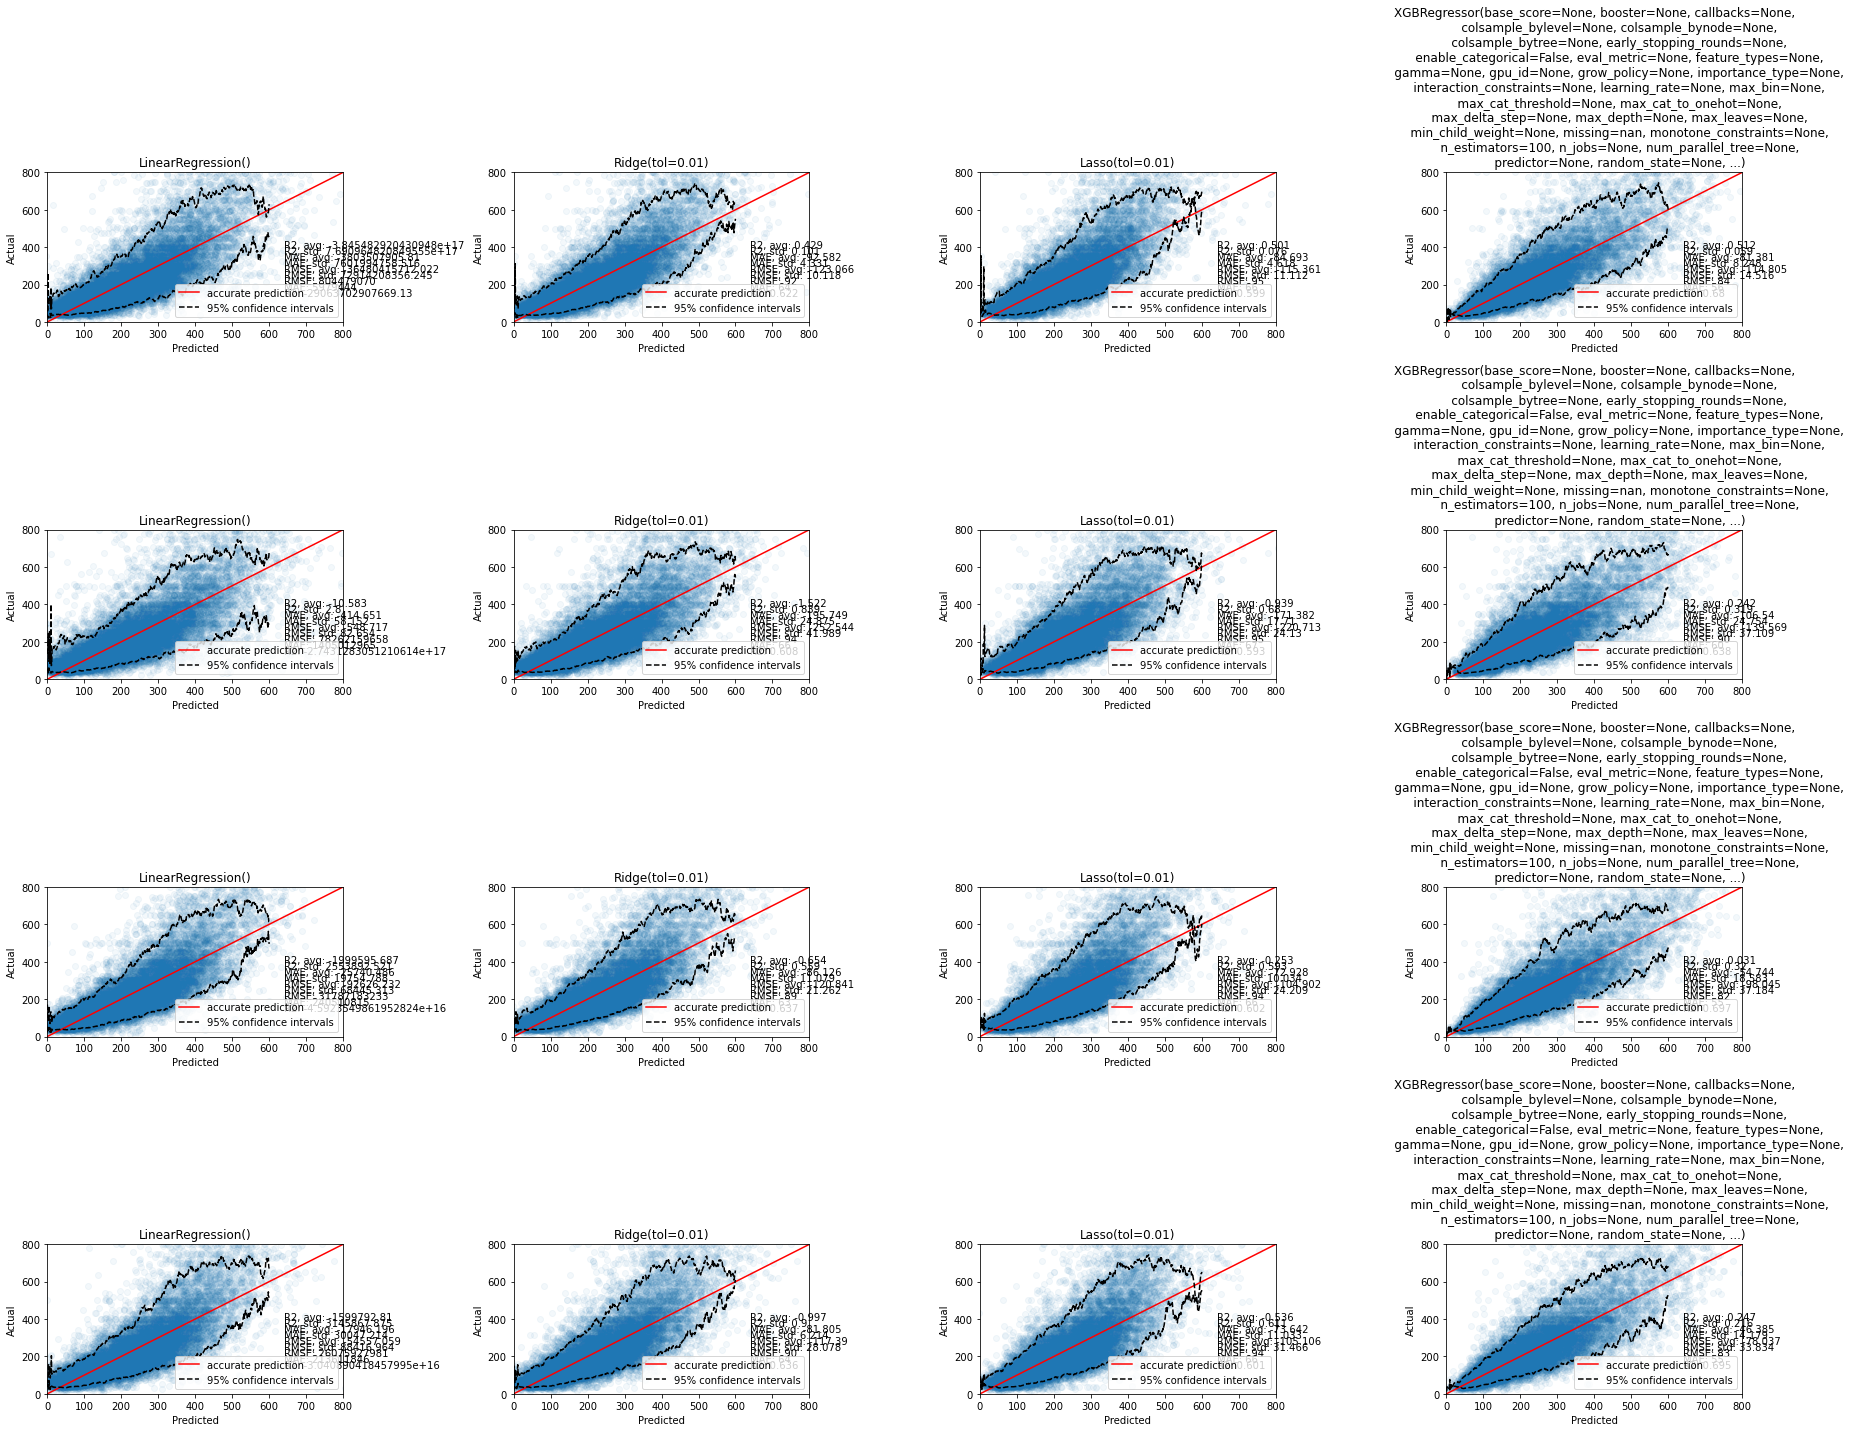

In [29]:
# Create subplots.
fig, axes = plt.subplots(4, 4, figsize=(25, 20))
axes = axes.flatten()

# Create models.
# Hypothesis: larger tol will help with convergence errors.
models=[LinearRegression(), Ridge(tol=0.01), Lasso(tol=0.01),XGBRegressor(),
        LinearRegression(), Ridge(tol=0.01), Lasso(tol=0.01),XGBRegressor(),
       LinearRegression(), Ridge(tol=0.01), Lasso(tol=0.01),XGBRegressor(),
       LinearRegression(), Ridge(tol=0.01), Lasso(tol=0.01),XGBRegressor()]
# Create partitions.
partitions=['mahalanobis_100','mahalanobis_100','mahalanobis_100','mahalanobis_100',
            'wminkowski_500','wminkowski_500','wminkowski_500','wminkowski_500',
           'cos100','cos100','cos100','cos100',
           'cor100','cor100','cor100','cor100']

# Loop through to create chart.
for i, ax in tqdm(enumerate(axes)):
    gen_many_models(X=X,y=y,model=models[i],ax=ax,partition=partitions[i],polynomial=False)
    
plt.tight_layout()


### 2-Degree Polynomial Linear, Ridge, Lasso partitioned by state and cluster.
**Abandoned in final model.**

In [ ]:
"""
fig, axes = plt.subplots(4, 4, figsize=(23, 20))
axes = axes.flatten()

models=[LinearRegression(), Ridge(tol=0.01), Lasso(tol=0.01),RandomForestRegressor(n_jobs=-1),
        LinearRegression(), Ridge(tol=0.01), Lasso(tol=0.01),RandomForestRegressor(n_jobs=-1),
       LinearRegression(), Ridge(tol=0.01), Lasso(tol=0.01),RandomForestRegressor(n_jobs=-1),
       LinearRegression(), Ridge(tol=0.01), Lasso(tol=0.01),RandomForestRegressor(n_jobs=-1)]

partitions=['mahalanobis_100','mahalanobis_100','mahalanobis_100','mahalanobis_100',
            'wminkowski_500','wminkowski_500','wminkowski_500','wminkowski_500',
           'cos100','cos100','cos100','cos100',
           'cor100','cor100','cor100','cor100']


for i, ax in tqdm(enumerate(axes)):
    gen_many_models(X=X,y=y,model=models[i],ax=ax,partition=partitions[i],level='state',polynomial=2)
    
plt.tight_layout()
"""

# Tuning RandomForestRegressor

Tune a RandomForest Regressor model, and compare it against an untuned model.

In [30]:
def gen_tuned_randomforestregressor(X,y,model,ax):
    
    # Copy data.
    X_ = X.copy()
    y_ = y.copy()
    
    # Train test split.
    X_train, X_test, y_train, y_test = train_test_split(
            X_, y_, test_size=0.2, random_state=0
        )
    
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(5, 80, num = 5)]
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    # Random search of parameters, using 3 fold cross validation, 
    # search across 10 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = model, 
                                   param_distributions = random_grid, 
                                   n_iter = 10, 
                                   cv = 3, 
                                   random_state=42, 
                                   n_jobs = -1,
                                   scoring='r2',
                                   verbose=4)
    # Fit the random search model
    rf_random.fit(X_train, y_train)
    
    # Set best params to the model.
    model.set_params(**rf_random.best_params_)
    
    # Fit model.
    model.fit(X_train, y_train)
    
    # Make prediction.
    y_pred = model.predict(X_test)
    
    # Create 1-fold metrics.
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Create 5-fold metrics.
    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    r2_scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=cv, n_jobs=-1)
    mae_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    rmse_scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    
    # Create confidence intervals.
    floor, roof = confidence_intervals(y_pred, y_test)
    
    # Create delimiter.
    try:
        delimiter = min([max([max(y_pred)[0], max(y_test.values)[0]]),800])
    except:
        delimiter = min([max([y_pred.max(), y_test.max()]),800])
    
    # Create chart.
    ax.scatter(y_pred, y_test, alpha=0.05)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xlim(0, delimiter)
    ax.set_ylim(0, delimiter)
    ax.set_title(str(model))
    ax.text(delimiter*.8, delimiter*.49, 'R2, avg: {}'.format(round(np.mean(r2_scores),3)))
    ax.text(delimiter*.8, delimiter*.45, 'R2, std: {}'.format(round(np.std(r2_scores),3)))
    ax.text(delimiter*.8, delimiter*.41, 'MAE, avg: {}'.format(round(np.mean(mae_scores),3)))
    ax.text(delimiter*.8, delimiter*.37, 'MAE, std: {}'.format(round(np.std(mae_scores),3)))
    ax.text(delimiter*.8, delimiter*.33, 'RMSE, avg: {}'.format(round(np.mean(rmse_scores),3)))
    ax.text(delimiter*.8, delimiter*.29, 'RMSE, std: {}'.format(round(np.std(rmse_scores),3)))
    ax.text(delimiter*.8, delimiter*.25, 'RMSE: {}'.format(round(rmse)))
    ax.text(delimiter*.8, delimiter*.21, 'MAE: {}'.format(round(mae)))
    ax.text(delimiter*.8, delimiter*.17, 'R2: {}'.format(round(r2,3)))
    
    ax.plot(np.linspace(0, round(delimiter), round(delimiter)*100), 
             np.linspace(0, round(delimiter), round(delimiter)*100),
            c='red',label='accurate prediction')
    
    ax.plot(range(0,601), roof, c='k',linestyle='dashed',label='95% confidence intervals')
    ax.plot(range(0,601), floor, c='k',linestyle='dashed')
    ax.legend()
    
    
    

In [ ]:
# Create subplots.
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes = axes.flatten()

# Create models.
models=[RandomForestRegressor(n_jobs=-1),RandomForestRegressor(n_jobs=-1)]

# Loop through and create charts.
for i, ax in tqdm(enumerate(axes)):
    if i == 0:
        gen_tuned_randomforestregressor(X,y,models[i],ax)
    elif i == 1:
        gen_model(X,y,models[i],ax)
    
plt.tight_layout()


In [ ]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(23, 20))
axes = axes.flatten()

# List of models.
models=[LinearRegression(),
        RandomForestRegressor(n_jobs=-1),
        RandomForestRegressor(bootstrap=False, max_depth=80,max_features='sqrt',min_samples_split=5,n_estimators=138,n_jobs=-1),
        RandomForestRegressor(bootstrap=False, max_depth=80,max_features='sqrt',min_samples_split=5,n_estimators=138,n_jobs=-1)]

# Partitions.
partitions=[None, None, None, 'cos100']

# Loop through and make charts.
for i, ax in tqdm(enumerate(axes)):
    if i == 3:
        gen_many_models(X=X,y=y,model=models[i],ax=ax,partition=partitions[i],level='state')
    else:
        gen_model(X=X, y=y, model=models[i], ax=ax)
        
    
plt.tight_layout()


# Tuning XGBoostRegressor

In [31]:
def gen_tuned_xgboostregressor(X,y,model,ax,log=False):
    
    # Copy data.
    X_ = X.copy()
    y_ = y.copy()
    
    # Test train split.
    X_train, X_test, y_train, y_test = train_test_split(
            X_, y_, test_size=0.2, random_state=0
        )
    
    # Log transform: abandoned.
    if log == True:
        y_train = np.log(y_train)
        y_test = np.log(y_test)
    
    # Grid of parameters to search.
    random_grid = {
              'objective':['reg:squarederror'],
              'booster':['gbtree','gblinear'],
              'learning_rate': [0.05, 0.1, 0.15], 
              'max_depth': [7,10,15,20],
              'min_child_weight': [10,15,20,25],
              'colsample_bytree': [0.8, 0.9, 1],
              'n_estimators': [100,200,300,400],
              "reg_alpha"   : [0.5,0.2,1],
              "reg_lambda"  : [2,3,5],
              "gamma"       : [1,2,3]
    }
    
    # Random search of parameters, using 3 fold cross validation, 
    # search across 10 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = model, 
                                   param_distributions = random_grid, 
                                   n_iter = 50, 
                                   cv = 3, 
                                   random_state=42, 
                                   n_jobs = -1,
                                   scoring='r2',
                                   verbose=4)
    
    # Grid search.
    rf_random.fit(X_train, y_train)
        
    # Set the parameters with the best results for the grid search.
    model.set_params(**rf_random.best_params_)
    
    # Fit the model.
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate 1-fold metrics.
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Calculate 5-fold metric on X_train.
    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    r2_scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=cv, n_jobs=-1)
    mae_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    rmse_scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    
    # Calculate the confidence intervals.
    floor, roof = confidence_intervals(y_pred, y_test)
    
    # Calculate delimiter.
    try:
        delimiter = min([max([max(y_pred)[0], max(y_test.values)[0]]),800])
    except:
        delimiter = min([max([y_pred.max(), y_test.max()]),800])
    
    # Create chart.
    ax.scatter(y_pred, y_test, alpha=0.05)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xlim(0, delimiter)
    ax.set_ylim(0, delimiter)
    ax.set_title(str(model))
    ax.text(delimiter*.8, delimiter*.49, 'R2, avg: {}'.format(round(np.mean(r2_scores),3)))
    ax.text(delimiter*.8, delimiter*.45, 'R2, std: {}'.format(round(np.std(r2_scores),3)))
    ax.text(delimiter*.8, delimiter*.41, 'MAE, avg: {}'.format(round(np.mean(mae_scores),3)))
    ax.text(delimiter*.8, delimiter*.37, 'MAE, std: {}'.format(round(np.std(mae_scores),3)))
    ax.text(delimiter*.8, delimiter*.33, 'RMSE, avg: {}'.format(round(np.mean(rmse_scores),3)))
    ax.text(delimiter*.8, delimiter*.29, 'RMSE, std: {}'.format(round(np.std(rmse_scores),3)))
    ax.text(delimiter*.8, delimiter*.25, 'RMSE: {}'.format(round(rmse)))
    ax.text(delimiter*.8, delimiter*.21, 'MAE: {}'.format(round(mae)))
    ax.text(delimiter*.8, delimiter*.17, 'R2: {}'.format(round(r2,3)))
    
    ax.plot(np.linspace(0, round(delimiter), round(delimiter)*100), 
             np.linspace(0, round(delimiter), round(delimiter)*100),
            c='red',label='accurate prediction')
    
    ax.plot(range(0,601), roof, c='k',linestyle='dashed',label='95% confidence intervals')
    ax.plot(range(0,601), floor, c='k',linestyle='dashed')
    ax.legend()
    
    return y_pred, y_test
    
    
    

In [ ]:
# Create subplot.
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes = axes.flatten()

# Short cut: save the tuned model found from the prior function, and fetch it with gen model. 
# Faster computation time!
tuned_xgb = XGBRegressor(objective='reg:squarederror',
             booster='gbtree',
             learning_rate=0.1,
             max_depth=20,
             min_child_weight=25,
            colsample_bytree=0.8,
            n_estimators=400,
            reg_alpha=1, #
            reg_lambda=2, #
            gamma=1, #
            n_jobs=-1,
            random_state=0)

# Create list of models.
models=[tuned_xgb, XGBRegressor(n_jobs=-1,random_state=0)]

# Loop through to build charts.
for i, ax in tqdm(enumerate(axes)):
    if i == 0:
        #xgboostregressor_pred, xgboostregressor_test = gen_tuned_xgboostregressor(X,y,models[i],ax,log=False)
        xgboostregressor_pred, xgboostregressor_test, map_frame = gen_model(X,y,models[i],ax,log=False)
    elif i == 1:
        _,_,_ = gen_model(X,y,models[i],ax)
    
plt.tight_layout()


# Log-scale.

While a log-linear increased the R-Squared score, I abandoned it because the log of price is not a helpful outcome for my model.

In [ ]:
"""
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes = axes.flatten()

models=[XGBRegressor(n_jobs=-1,random_state=0), XGBRegressor(n_jobs=-1,random_state=0)]

for i, ax in tqdm(enumerate(axes)):
    if i == 0:
        xgboostregressor_pred_normal, xgboostregressor_test_normal = gen_tuned_xgboostregressor(X,y,models[i],ax,log=True)
    elif i == 1:
        gen_model(X,y,models[i],ax)
    
plt.tight_layout()
"""

In [ ]:
# Create subplots.
fig, axes = plt.subplots(2, 2, figsize=(23, 20))
axes = axes.flatten()

# Save tuned model from gridsearch.
tuned_xgb = XGBRegressor(objective='reg:squarederror',
             booster='gbtree',
             learning_rate=0.1,
             max_depth=20,
             min_child_weight=25,
            colsample_bytree=0.8,
            n_estimators=400,
            reg_alpha=1, #
            reg_lambda=2, #
            gamma=1, #
            n_jobs=-1)

# Create list of models.
models=[LinearRegression(),
        XGBRegressor(n_jobs=-1),
        tuned_xgb,
        tuned_xgb]

# Create list of partitions.
partitions=[None, None, None, 'cos100']

# Loop through to generate charts.
# First 3 are gen_many_models. Last one is gen_models.
for i, ax in tqdm(enumerate(axes)):
    if i == 3:
        gen_many_models(X=X,y=y,model=models[i],ax=ax,partition=partitions[i],level='state')
    else:
        gen_model(X=X, y=y, model=models[i], ax=ax)
        
    
plt.tight_layout()

In [ ]:
def gen_tuned_partitioned_xgboostregressor(X,y,model,ax,partition='cos100',level='state'):
    
    X_ = X.copy()
    y_ = y.copy()
    
    y_pred_list = []
    y_test_list = []
    
    if level == 'state':
        states = [state for state in airbnb_df.state.unique()]
        clusters = [cluster for cluster in airbnb_df[partition].unique()]

        filter_parameters = []

        # Append each unique metric-neighbor combination to model_parameters.
        for state in states:
            for cluster in clusters:
                filter_parameters.append((state, cluster))
    
    elif level == 'city':
        states = [state for state in airbnb_df.state.unique()]
        clusters = [cluster for cluster in airbnb_df[partition].unique()]
        cities = [city for city in airbnb_df.city.unique()]

        filter_parameters = []

        # Append each unique metric-neighbor combination to model_parameters.
        for state in states:
            for cluster in clusters:
                for city in airbnb_df[airbnb_df['state']==state].city.unique():
                    filter_parameters.append((state, cluster, city))
    
    for filter_param in filter_parameters:
        
        if level == 'state':
            state = filter_param[0]
            cluster = filter_param[1]

            indices = airbnb_df[(airbnb_df['state'] == state) & (airbnb_df[partition] == cluster)].index
        elif level == 'city':
            state = filter_param[0]
            cluster = filter_param[1]
            city = filter_param[2]
            
            indices = airbnb_df[(airbnb_df['state'] == state) & (airbnb_df['city'] == city) & (airbnb_df[partition] == cluster)].index
            

        X_small = X_[indices]
        y_small = y_[indices]
        
        if len(X_small) <= 10:
            pass
        else:
            X_train, X_test, y_train, y_test = train_test_split(
                    X_small, y_small, test_size=0.2, random_state=0
                )
            
            # Specify grid parameter of features to test.
            random_grid = {
              'objective':['reg:squarederror'],
              'booster':['gbtree','gblinear'],
              'learning_rate': [0.05, 0.1, 0.15], 
              'max_depth': [7,10,15,20],
              'min_child_weight': [10,15,20,25],
              'colsample_bytree': [0.8, 0.9, 1],
              'n_estimators': [100,200,300,400],
              "reg_alpha"   : [0.5,0.2,1],
              "reg_lambda"  : [2,3,5],
              "gamma"       : [1,2,3]
            }

            # Random search of parameters, using 3 fold cross validation, 
            # search across 10 different combinations, and use all available cores
            rf_random = RandomizedSearchCV(estimator = model, 
                                           param_distributions = random_grid, 
                                           n_iter = 20, 
                                           cv = 3, 
                                           random_state=42, 
                                           n_jobs = -1,
                                           scoring='r2',
                                           verbose=4)
            # Fit the random search model
            rf_random.fit(X_train, y_train)
            
            # Set model params to match winning model.
            model.set_params(**rf_random.best_params_)            
            
            # Train on training data.
            model.fit(X_train, y_train)
            
            # Make predictions.
            y_pred = model.predict(X_test)
            
            # Append predictions and test values.
            y_pred_list.append(y_pred)
            y_test_list.append(y_test)
    
    # Unpack values into one array.
    y_pred_list= np.concatenate(y_pred_list)
    y_test_list= np.concatenate(y_test_list)
    
    # Single fold metrics.
    rmse = mean_squared_error(y_test_list, y_pred_list, squared=False)
    mae = mean_absolute_error(y_test_list, y_pred_list)
    r2 = r2_score(y_test_list, y_pred_list)
    
    # 5-fold metrics on X_train.
    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    r2_scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=cv, n_jobs=-1)
    mae_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    rmse_scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    
    # Values for confidence intervals.
    floor, roof = confidence_intervals(y_pred_list, y_test_list)
    
    # Calculate the delimiter.
    try:
        delimiter = min([max([max(y_pred_list)[0], max(y_test_list.values)[0]]),800])
    except:
        delimiter = min([max([y_pred_list.max(), y_test_list.max()]),800])
    
    # Build chart.
    ax.scatter(y_pred_list, y_test_list, alpha=0.05)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xlim(0, delimiter)
    ax.set_ylim(0, delimiter)
    ax.set_title(str(model))
    ax.text(delimiter*.8, delimiter*.49, 'R2, avg: {}'.format(round(np.mean(r2_scores),3)))
    ax.text(delimiter*.8, delimiter*.45, 'R2, std: {}'.format(round(np.std(r2_scores),3)))
    ax.text(delimiter*.8, delimiter*.41, 'MAE, avg: {}'.format(round(np.mean(mae_scores),3)))
    ax.text(delimiter*.8, delimiter*.37, 'MAE, std: {}'.format(round(np.std(mae_scores),3)))
    ax.text(delimiter*.8, delimiter*.33, 'RMSE, avg: {}'.format(round(np.mean(rmse_scores),3)))
    ax.text(delimiter*.8, delimiter*.29, 'RMSE, std: {}'.format(round(np.std(rmse_scores),3)))
    ax.text(delimiter*.8, delimiter*.25, 'RMSE: {}'.format(round(rmse)))
    ax.text(delimiter*.8, delimiter*.21, 'MAE: {}'.format(round(mae)))
    ax.text(delimiter*.8, delimiter*.17, 'R2: {}'.format(round(r2,3)))
    
    ax.plot(np.linspace(0, round(delimiter), round(delimiter)*100), 
             np.linspace(0, round(delimiter), round(delimiter)*100),
            c='red',label='accurate prediction')
    
    ax.plot(range(0,601), roof, c='k',linestyle='dashed',label='95% confidence intervals')
    ax.plot(range(0,601), floor, c='k',linestyle='dashed')
    ax.legend()
    
    # Return preds and actual.
    return y_pred_list, y_test_list
    
    
    

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes = axes.flatten()

models=[XGBRegressor(n_jobs=-1), XGBRegressor(n_jobs=-1)]

for i, ax in tqdm(enumerate(axes)):
    if i == 0:
        xghboostregressor_preds_partitioned, xgboostregressor_tests_partitioned = gen_tuned_partitioned_xgboostregressor(X,y,models[i],ax)
    elif i == 1:
        gen_model(X,y,models[i],ax)
    
plt.tight_layout()

# Ablation and Feature Importance Study

Using the leading model, let's see if we can figure out which features have the most predictive power in the model. In the absence of a model with a higher r2 score, this can help us better understand the features with the most predictive power.

In [32]:
count = 0
for col in airbnb_model.drop(columns=['price']).columns:
    print(count, col)
    count += 1

0 is_superhost
1 is_premium
2 rating
3 n_reviews
4 n_pictures
5 entire_home
6 hotel_room
7 private_room
8 shared_room
9 perc_discount
10 n_guests
11 n_bedrooms
12 n_beds
13 n_baths
14 rating_cleanliness
15 rating_communication
16 rating_checkin
17 rating_accuracy
18 rating_location
19 rating_value
20 n_amenities
21 amenities_services
22 amenities_heat_cool
23 amenities_bedroom_laundry
24 amenities_kitchen_dining
25 amenities_safety
26 amenities_parking_facilities
27 amenities_internet_office
28 amenities_not_included
29 amenities_entertainment
30 amenities_bathroom
31 amenities_outdoor
32 amenities_location_features
33 amenities_family
34 amenities_scenic_views
35 bed_king
36 bed_queen
37 bed_double
38 bed_single
39 bed_sofa
40 bed_air
41 bed_floor
42 bed_bunkbed
43 bed_hammock
44 bed_baby
45 description_sentiment_score
46 description_length
47 description_reading_level
48 pca_1st_component
49 pca_2nd_component
50 pca_3rd_component
51 pca_4th_component
52 pca_5th_component
53 arches
54

In [33]:
general_info = [0:14]
ratings = [14:20]
amenities = [20:35]
beds = [35:45]
description = [45:48]
pca = [48:53]
destinations = [53:201]

SyntaxError: invalid syntax (<ipython-input-33-7ac2f8fccf7b>, line 1)

In [34]:
ablation_segments = [('general_info', 0,14),
                     ('ratings',14,20),
                     ('amenities',20,35),
                     ('beds',35,45),
                     ('description',45,48),
                     ('pca_location',48,53),
                     ('destination',53,201),
                     ('image_quality',201, 211),
                     ('unigrams',211,255)]


9it [9:38:29, 3856.67s/it]


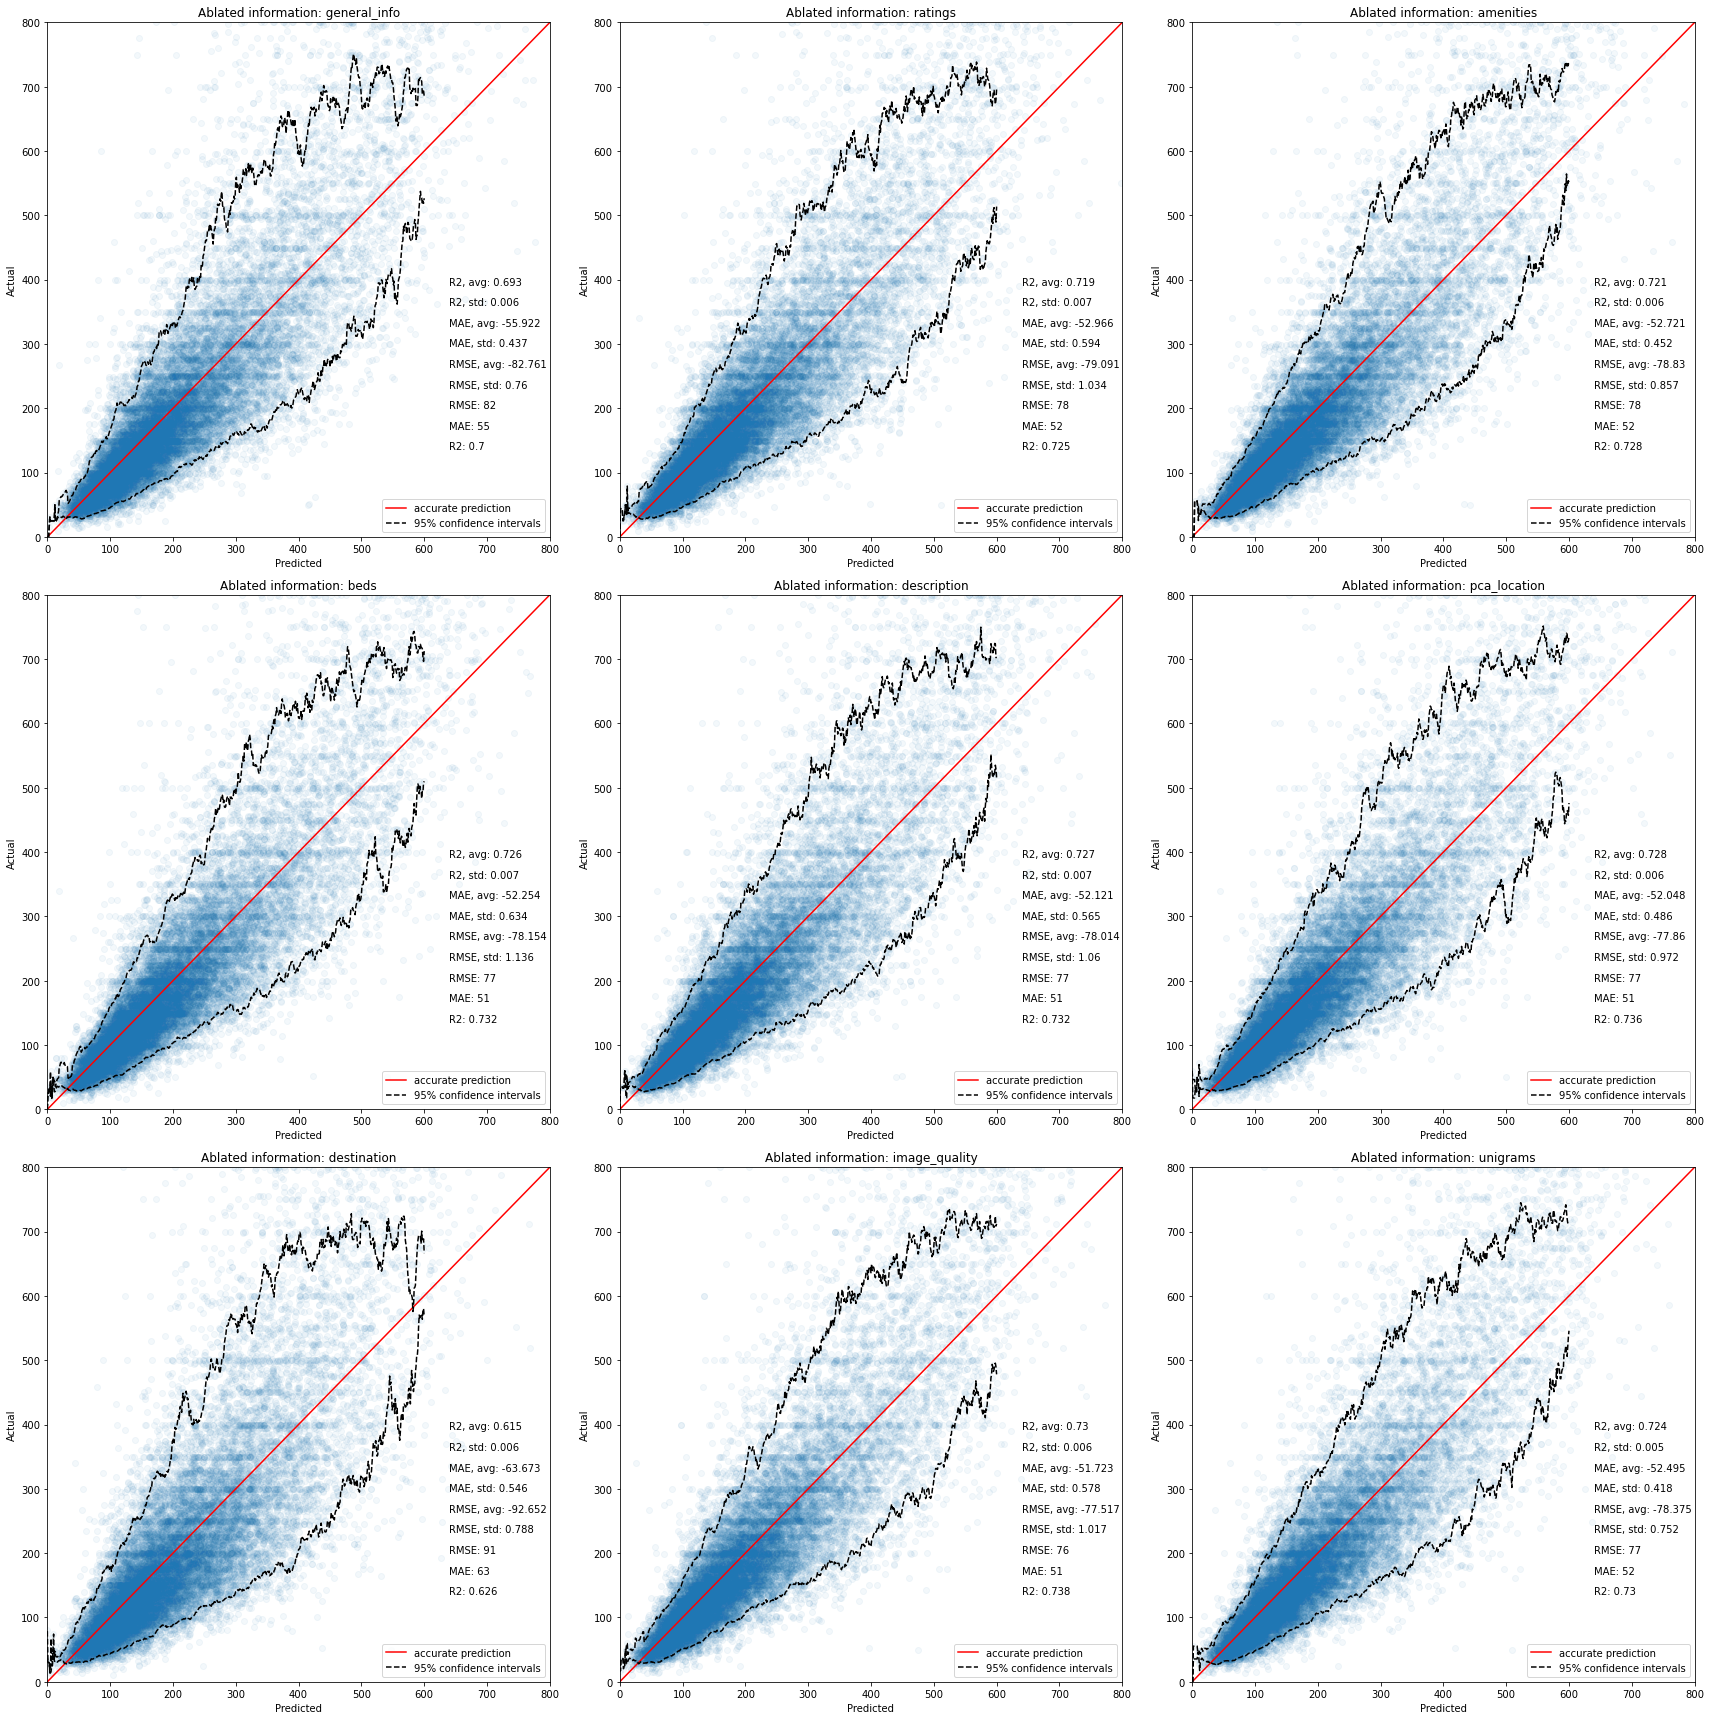

In [35]:
fig, axes = plt.subplots(3, 3, figsize=(24, 24))
axes = axes.flatten()

model = XGBRegressor(
            objective='reg:squarederror',
            booster='gbtree',
            learning_rate=0.1,
            max_depth=10,
            min_child_weight=25,
            colsample_bytree=0.8,
            n_estimators=400,
            reg_alpha=0.2,#
            reg_lambda=3,#
            gamma=1,
            n_jobs=-1,
            random_state=0
        )


for i, ax in tqdm(enumerate(axes)):
    min_ = ablation_segments[i][1]
    max_ = ablation_segments[i][2]
    gen_model(np.delete(X,np.s_[min_:max_],axis=1),y,model,ax)
    ax.set_title('Ablated information: {}'.format(ablation_segments[i][0]))

    
plt.tight_layout()

In [ ]:
def feature_importance(model):
    
    X_ = X.copy()
    y_ = y.copy()
        

    X_train, X_test, y_train, y_test = train_test_split(
            X_, y_, test_size=0.3, random_state=0
        )

    
    model.fit(X_train, y_train)
    
    features = model.feature_importances_
    
    sorted_idx = model.feature_importances_.argsort()
    plt.figure(figsize=(6,40))

    
    plt.barh(airbnb_model.drop(columns=['price']).columns[sorted_idx], model.feature_importances_[sorted_idx])
    plt.xlabel('Feature Importance')


In [ ]:
# Create model.
model = XGBRegressor(random_state=0,
            objective='reg:squarederror',
            booster='gbtree',
            learning_rate=0.15,
            max_depth=20,
            min_child_weight=10,
            colsample_bytree=1,
            n_estimators=200,
            reg_alpha=.2,#guess
            reg_lambda=3,#guess
            gamma=1
)


feature_importance(model)

# Analyzing Success and Failures in the model

Let's take a look at the leading model and categorize the success and failures of the model.

In [ ]:
def partitioned_results_df(y_pred, y_test):
    
    errors = y_pred - y_test
    
    data = {
        'y_pred':y_pred,
        'y_test':y_test,
        'errors':errors
    }
    
    frame = pd.DataFrame(data=data)
    
    bins = []
    perc_bins = []
    price = []
    
    for i, row in frame.iterrows():
        
        # categorize by error.
        if row['errors'] <= -100:
            bins.append('1: Underpredicted: >=100USD')
        elif row['errors'] <= -50:
            bins.append('2: Underpredicted: 50-99USD')
        elif row['errors'] <= -25:
            bins.append('3: Underpredicted: 25-49USD')
        elif row['errors'] <= -10:
            bins.append('4: Underpredicted: 10-24USD')
        elif row['errors'] <= 10:
            bins.append('5: Optimal prediction: +/-10USD')
        elif row['errors'] < 25:
            bins.append('6: Overpredicted: 10-25USD')
        elif row['errors'] < 50:
            bins.append('7: Overpredicted: 25-49USD')
        elif row['errors'] < 100:
            bins.append('8: Overpredicted: 50-99USD')
        else:
            bins.append('9: Overpredicted: >=100USD')
            
        #categorize by original price.
        if row['y_test'] >= 0. and row['y_test'] < 50.:
            price.append('1: 0-49.99USD')
        elif row['y_test'] >= 50. and row['y_test'] < 100.:
            price.append('2: 50-99.99USD')
        elif row['y_test'] >= 100. and row['y_test'] < 200.:
            price.append('3: 100-199.99USD')
        elif row['y_test'] >= 200. and row['y_test'] < 300.:
            price.append('4: 200-300USD')
        elif row['y_test'] >= 300. and row['y_test'] < 450.:
            price.append('5: 300-449.99USD')
        elif row['y_test'] >= 450. and row['y_test'] < 600.:
            price.append('6: 450-599.99USD')
        elif row['y_test'] >= 600.:
            price.append('7: 600USD or greater')
        else:
            price.append('Uncategorized')   
            
        # categorize by percent error.
        if (row['errors'] + row['y_test'])/row['y_test'] >= 2:
            perc_bins.append('1: 200% of price or greater')
        elif (row['errors'] + row['y_test'])/row['y_test'] >= 1.5:
            perc_bins.append('2: 150-199% of price')
        elif (row['errors'] + row['y_test'])/row['y_test'] >= 1.25:
            perc_bins.append('3: 125-150% of price')
        elif (row['errors'] + row['y_test'])/row['y_test'] >= 1.10:
            perc_bins.append('4: 110-124% of price')
        elif (row['errors'] + row['y_test'])/row['y_test'] >= .9:
            perc_bins.append('5: 90-109% of price')
        elif (row['errors'] + row['y_test'])/row['y_test'] >= .75:
            perc_bins.append('6: 75%-89% of price')
        elif (row['errors'] + row['y_test'])/row['y_test'] >= .50:
            perc_bins.append('7: 50-74% of price')
        elif (row['errors'] + row['y_test'])/row['y_test'] >= .25:
            perc_bins.append('8: 25-49% of price')
        else:
            perc_bins.append('25% of price or lower')

            
    frame['bin'] = bins
    frame['perc_bins'] = perc_bins
    frame['price'] = price
    
    return (frame[['price','perc_bins']]
            .groupby(['price','perc_bins'])
            .size()
            .reset_index()
            .sort_values(by=['price','perc_bins'])
            .pivot(index='perc_bins', columns='price', values=0)
            .fillna(0))
    

In [ ]:
results_df = partitioned_results_df(xgboostregressor_pred, xgboostregressor_test)

In [ ]:
plt.figure(figsize=(20,10))

#sns.heatmap(results_df.div(results_df.sum(axis=1), axis=0), cmap ='RdYlGn', linewidths = 0.30, annot = True, fmt='.1f')

ax = sns.heatmap(results_df, cmap ='RdYlGn', linewidths = 0.30, annot = True, fmt='.0f',center=400)

plt.show()

In [ ]:
results_df_perc = pd.DataFrame()

for col in results_df.columns:
    results_df_perc[col] = (results_df[col] / results_df[col].sum()) * 100


results_df_perc.set_index(results_df.index, inplace=True)

plt.figure(figsize=(20,10))

#sns.heatmap(results_df.div(results_df.sum(axis=1), axis=0), cmap ='RdYlGn', linewidths = 0.30, annot = True, fmt='.1f')

ax = sns.heatmap(results_df_perc, cmap ='RdYlGn', linewidths = 0.30, annot = True, fmt='.2f',center=30)
for t in ax.texts: t.set_text(t.get_text() + " %")


plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(xgboostregressor_tests,label='Actual')
plt.hist(xghboostregressor_preds,label='Predicted')
plt.legend()
plt.xlabel('Price USD')
plt.ylabel('# of Listings')
plt.title('Predicted vs. Actual')
plt.show()

In [ ]:
def partition_r2(y_pred, y_test):
    
    errors = y_pred - y_test
    
    data = {
        'y_pred':y_pred,
        'y_test':y_test,
        'errors':errors
    }
    
    frame = pd.DataFrame(data=data)
    
    for ranges in [(0,50),(50,100),(100,200),(200,300),(300,450),(450,600),(600,1e7)]:
        partition = frame[(frame['y_test'] >= ranges[0]) & (frame['y_test'] < ranges[1])]
        
        print('Partition: ${}-${} USD'.format(ranges[0], ranges[1]))
        print('# of listings: {}'.format(len(partition)))
        print('r2 score: {}'.format(r2_score(partition['y_test'], partition['y_pred'])))
        print('\n')

In [ ]:
partition_r2(xgboostregressor_pred, xgboostregressor_test)

In [ ]:
def partition_mae(y_pred, y_test):
    
    errors = y_pred - y_test
    
    data = {
        'y_pred':y_pred,
        'y_test':y_test,
        'errors':errors
    }
    
    frame = pd.DataFrame(data=data)
    
    for ranges in [(0,50),(50,100),(100,200),(200,300),(300,450),(450,600),(600,801)]:
        partition = frame[(frame['y_test'] >= ranges[0]) & (frame['y_test'] < ranges[1])]
        
        mae = mean_absolute_error(partition['y_test'], partition['y_pred'])
        mean_price = sum([ranges[0], ranges[1]])/2
        pct_mean_error = (mae+mean_price)/mean_price-1
        
        print('Partition: ${}-${} USD'.format(ranges[0], ranges[1]))
        print('# of listings: {}'.format(len(partition)))
        print('MAE score: {}'.format(mae))
        print('% MAE score: {}'.format(round(pct_mean_error*100),2))
        print('\n')

In [ ]:
partition_mae(xgboostregressor_pred, xgboostregressor_test)

In [ ]:
def failure_dataframe(y_pred, y_test, map_frame=map_frame):
    
    errors = y_pred - y_test
    
    data = {
        'y_pred':y_pred,
        'y_test':y_test,
        'errors':errors,
        'original_index': [x[0] for x in map_frame]
    }
    
    frame = pd.DataFrame(data=data)
    
    return frame

failure_df = failure_dataframe(xgboostregressor_pred, xgboostregressor_test)

In [ ]:
failure_df.sort_values(by='errors',ascending=True)[:20]

In [ ]:
airbnb_df.iloc[9393][:50]

In [ ]:
failure_df.sort_values(by='errors',ascending=False)[:20]

In [ ]:
airbnb_df.iloc[53330][:50]

# Sensitivity Analysis 

In [ ]:
def gen_model_sensitivity(X,y,model=tuned_xgb):
    
    X_ = X.copy()
    y_ = y.copy()

    X_train, X_test, y_train, y_test = train_test_split(
            X_, y_, test_size=0.2, random_state=0
        )
    
    random_grid = {
              'objective':['reg:squarederror'],
              'booster':['gbtree','gblinear'],
              'learning_rate': [0.05, 0.1, 0.15], 
              'max_depth': [7,10,15,20],
              'min_child_weight': [10,15,20,25],
              'colsample_bytree': [0.8, 0.9, 1],
              'n_estimators': [100,200,300,400],
              "reg_alpha"   : [0.5,0.2,1],
              "reg_lambda"  : [2,3,5],
              "gamma"       : [1,2,3]
    }
    
    # Random search of parameters, using 3 fold cross validation, 
    # search across 10 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = model, 
                                   param_distributions = random_grid, 
                                   n_iter = 50, 
                                   cv = 3, 
                                   random_state=42, 
                                   n_jobs = -1,
                                   scoring='r2',
                                   verbose=4)
    
    rf_random.fit(X_train, y_train)
    
    results = pd.DataFrame(rf_random.cv_results_)
    return results

In [ ]:
sensitivty_results = gen_model_sensitivity(X,y)

In [ ]:
sensitivty_results

In [ ]:
plt.hist(sensitivty_results[sensitivty_results['param_booster']=='gblinear']['mean_test_score'],label='gblinear')
plt.hist(sensitivty_results[sensitivty_results['param_booster']=='gbtree']['mean_test_score'],label='gbtree')
plt.legend(title='Booster')